# Coursework Assignment: Bias in AI

Link to dataset used (given in 'Project Suggestions'): https://www.kaggle.com/kabure/german-credit-data-with-risk

## Setup

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from random import randint
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from itertools import product 
from math import inf
from math import ceil

In [29]:
# load the data
df = pd.read_csv("./data/german_credit_data.csv", index_col=0)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [31]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [32]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [33]:
df.drop(['Checking account', 'Saving accounts'], axis=1, inplace=True)

## Data analysis

In [34]:
# create age group column
df['Age_Group'] = np.nan

df.head()

,Age,Sex,Job,Housing,Credit amount,Duration,Purpose,Risk,Age_Group
0,67,male,2,own,1169,6,radio/TV,good,NaN
1,22,female,2,own,5951,48,radio/TV,bad,NaN
2,49,male,1,own,2096,12,education,good,NaN
3,45,male,2,free,7882,42,furniture/equipment,good,NaN
4,53,male,2,free,4870,24,car,bad,NaN


In [35]:
# populate age group column
for col in [df]:
    col.loc[(col['Age'] > 18) & (col['Age'] <= 29), 'Age_Group'] = 'Young'
    col.loc[(col['Age'] > 29) & (col['Age'] <= 40), 'Age_Group'] = 'Young Adults'
    col.loc[(col['Age'] > 40) & (col['Age'] <= 55), 'Age_Group'] = 'Senior'
    col.loc[col['Age'] > 55, 'Age_Group'] = 'Elder' 

df.drop(['Age'], axis=1, inplace=True)
df.head()

,Sex,Job,Housing,Credit amount,Duration,Purpose,Risk,Age_Group
0,male,2,own,1169,6,radio/TV,good,Elder
1,female,2,own,5951,48,radio/TV,bad,Young
2,male,1,own,2096,12,education,good,Senior
3,male,2,free,7882,42,furniture/equipment,good,Senior
4,male,2,free,4870,24,car,bad,Senior


In [36]:
df['Sex'].value_counts()

male      690
female    310
Name: Sex, dtype: int64

In [37]:
df['Age_Group'].value_counts()

Young           371
Young Adults    355
Senior          203
Elder            71
Name: Age_Group, dtype: int64

In [38]:
def print_stats(df):
    print('mean: ', [round(num, 1) for num in list(df.mean())[1:]])
    print('variance: ', [round(num, 1) for num in list(df.var())[1:]])
    print('\n')
    zips = []
    for col in ['Housing', 'Purpose', 'Risk']:
       vals = df[col].value_counts().values
       inds = df[col].value_counts().index
       z = list(zip(inds, vals))[:3]
       if col == 'Risk':
           z.append('-')
       zips.append(z)
       print(z)
       print('\n')
    print(list(zip(zips[0], zips[1], zips[2])))

In [39]:
df_male = df[df['Sex'] == 'male']
print_stats(df_male)

mean:  [3448.0, 21.6]
variance:  [8412806.3, 154.7]


[('own', 517), ('free', 89), ('rent', 84)]


[('car', 243), ('radio/TV', 195), ('furniture/equipment', 107)]


[('good', 499), ('bad', 191), '-']


[(('own', 517), ('car', 243), ('good', 499)), (('free', 89), ('radio/TV', 195), ('bad', 191)), (('rent', 84), ('furniture/equipment', 107), '-')]


In [40]:
df_female = df[df['Sex'] == 'female']
print_stats(df_female)

mean:  [2877.8, 19.4]
variance:  [6776346.3, 122.1]


[('own', 196), ('rent', 95), ('free', 19)]


[('car', 94), ('radio/TV', 85), ('furniture/equipment', 74)]


[('good', 201), ('bad', 109), '-']


[(('own', 196), ('car', 94), ('good', 201)), (('rent', 95), ('radio/TV', 85), ('bad', 109)), (('free', 19), ('furniture/equipment', 74), '-')]


In [41]:
df_Young = df[df['Age_Group'] == 'Young']
print_stats(df_Young)

mean:  [3089.0, 20.8]
variance:  [7261837.7, 142.6]


[('own', 248), ('rent', 113), ('free', 10)]


[('radio/TV', 117), ('car', 102), ('furniture/equipment', 84)]


[('good', 234), ('bad', 137), '-']


[(('own', 248), ('radio/TV', 117), ('good', 234)), (('rent', 113), ('car', 102), ('bad', 137)), (('free', 10), ('furniture/equipment', 84), '-')]


In [42]:
df_YoungAdults = df[df['Age_Group'] == 'Young Adults']
print_stats(df_YoungAdults)

mean:  [3375.5, 21.5]
variance:  [7646336.1, 139.2]


[('own', 278), ('free', 39), ('rent', 38)]


[('car', 128), ('radio/TV', 93), ('furniture/equipment', 58)]


[('good', 264), ('bad', 91), '-']


[(('own', 278), ('car', 128), ('good', 264)), (('free', 39), ('radio/TV', 93), ('bad', 91)), (('rent', 38), ('furniture/equipment', 58), '-')]


In [43]:
df_Senior = df[df['Age_Group'] == 'Senior']
print_stats(df_Senior)

mean:  [3366.4, 20.2]
variance:  [7986564.4, 146.1]


[('own', 143), ('free', 40), ('rent', 20)]


[('car', 79), ('radio/TV', 51), ('furniture/equipment', 36)]


[('good', 150), ('bad', 53), '-']


[(('own', 143), ('car', 79), ('good', 150)), (('free', 40), ('radio/TV', 51), ('bad', 53)), (('rent', 20), ('furniture/equipment', 36), '-')]


In [44]:
df_Elder = df[df['Age_Group'] == 'Elder']
print_stats(df_Elder)

mean:  [3430.4, 20.5]
variance:  [13329819.2, 192.5]


[('own', 44), ('free', 19), ('rent', 8)]


[('car', 28), ('radio/TV', 19), ('business', 9)]


[('good', 52), ('bad', 19), '-']


[(('own', 44), ('car', 28), ('good', 52)), (('free', 19), ('radio/TV', 19), ('bad', 19)), (('rent', 8), ('business', 9), '-')]


In [45]:
for group in [df_male, df_female, df_Young, df_YoungAdults, df_Senior, df_Elder]:
    print(round(sum(group['Risk'] == 'bad')/len(group) * 100, 1))

27.7
35.2
36.9
25.6
26.1
26.8


## Conventional Implementation

In [46]:
# Create set of only independant variables by dropping Risk
X = df.drop(['Risk'], axis=1)
X.head()

,Sex,Job,Housing,Credit amount,Duration,Purpose,Age_Group
0,male,2,own,1169,6,radio/TV,Elder
1,female,2,own,5951,48,radio/TV,Young
2,male,1,own,2096,12,education,Senior
3,male,2,free,7882,42,furniture/equipment,Senior
4,male,2,free,4870,24,car,Senior


In [47]:
# Create a series of outcome variable only
y = df['Risk']
y.head()

0    good
1     bad
2    good
3    good
4     bad
Name: Risk, dtype: object

### Naive split

In [48]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit (self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

encode = LabelEncoder()

In [49]:
params = {'C': [0.75, 0.85, 0.95, 1], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [3, 4, 5]}

def pipe(X_train, X_test, y_train, y_test):
    numeric_train_df = X_train.select_dtypes(exclude=['object'])
    numeric_test_df = X_test.select_dtypes(exclude=['object'])

    categorical_train_df = X_train.select_dtypes(['object'])
    categorical_test_df = X_test.select_dtypes(['object'])

    numerical_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numeric_train_df.columns.values.tolist())),
        ("std_scaler", StandardScaler()),
    ])

    categorical_pipeline = Pipeline([
        ('select_categoric', DataFrameSelector(categorical_train_df.columns.values.tolist())),
        ('encoding', CategoricalEncoder(encoding='onehot-dense'))
    ])

    main_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', numerical_pipeline),
        ('cat_pipeline', categorical_pipeline)
    ])

    X_train_scaled = main_pipeline.fit_transform(X_train)
    X_test_scaled = main_pipeline.fit_transform(X_test)

    y_train_scaled = encode.fit_transform(y_train)
    y_test_scaled = encode.fit_transform(y_test)

    svc_clf = SVC(random_state=42)

    grid_search_cv = GridSearchCV(svc_clf, params)
    grid_search_cv.fit(X_train_scaled, y_train_scaled)

    svc_clf = grid_search_cv.best_estimator_
    print(svc_clf.fit(X_train_scaled, y_train_scaled))

    train_score = round(svc_clf.score(X_train_scaled, y_train_scaled) * 100, 1)
    cross_score = round(cross_val_score(svc_clf, X_train_scaled, y_train_scaled).mean() * 100, 1)
    
    y_pred = svc_clf.predict(X_test_scaled)
    test_score = round(accuracy_score(y_test_scaled, y_pred) * 100, 1)

    P = X_test[y_pred == 1]
    PCx = len(P[P['Sex'] == 'female']) / len(X_test[X_test['Sex'] == 'female'])
    PCxbar = len(P[P['Sex'] == 'male']) / len(X_test[X_test['Sex'] == 'male'])
    DI = round(PCx / PCxbar, 2)

    Zemel = round(PCxbar - PCx, 2)

    return train_score, cross_score, test_score, DI, Zemel

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
print(pipe(X_train, X_test, y_train, y_test))

SVC(C=0.75, degree=4, kernel='poly', random_state=42)
(80.2, 72.4, 69.2, 1.02, -0.01)


### Stratified split

In [51]:
df1 = df[(df['Sex'] == 'female') & (df['Risk'] == 'bad')]
df2 = df[(df['Sex'] == 'male') & (df['Risk'] == 'bad')].sample(109)
df3 = df[(df['Sex'] == 'female') & (df['Risk'] == 'good')].sample(109)
df4 = df[(df['Sex'] == 'male') & (df['Risk'] == 'good')].sample(109)
strat_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
strat_df['Sex'].value_counts()

female    218
male      218
Name: Sex, dtype: int64

In [52]:
stratified = StratifiedShuffleSplit(n_splits=1, test_size=1/3, random_state=42)

for train, test in stratified.split(strat_df, strat_df["Sex"]):
    strat_train = strat_df.loc[train]
    strat_test = strat_df.loc[test]
    
print('train', round(len(strat_train[strat_train['Sex'] == 'female']) * 100 / len(strat_train), 1)) 
print('test', round(len(strat_test[strat_test['Sex'] == 'female']) * 100 / len(strat_test), 1)) 

print(strat_train["Sex"].value_counts())

train = strat_train
test = strat_test

X_train = train.drop('Risk', axis=1)
X_test = test.drop('Risk', axis=1)
y_train = train["Risk"]
y_test = test["Risk"]

pipe(X_train, X_test, y_train, y_test)

train 50.0
test 50.0
male      145
female    145
Name: Sex, dtype: int64
SVC(C=0.75, random_state=42)


(74.8, 62.1, 55.5, 1.08, -0.03)

## Repair algorithm

In [26]:
# cartesian product
all_stratified_combinations = list(product(df['Sex'].unique(), df['Age_Group'].unique()))

combination_sizes = []
for combination in all_stratified_combinations:
    sex, age_group = combination
    combination_size = len(df[(df['Sex'] == sex) & (df['Age_Group'] == age_group)])
    combination_sizes.append(combination_size)
    if combination_size == 0:
        all_stratified_combinations.remove(combination)

number_of_quantiles = min(combination_sizes)

D_prime = df.copy()

In [27]:
Y_columns = list(D_prime.select_dtypes('number').columns)
Y_columns

['Job', 'Credit amount', 'Duration']

In [28]:
combination_sizes

[48, 200, 161, 281, 23, 171, 42, 74]

In [29]:
D_prime['Credit amount']

0      1169
1      5951
2      2096
3      7882
4      4870
       ... 
995    1736
996    3857
997     804
998    1845
999    4576
Name: Credit amount, Length: 1000, dtype: int64

In [30]:
def repair(Y_columns, all_stratified_groups, number_of_quantiles, lmbda, D_prime):
    quantile_unit = 1.0/number_of_quantiles
    column = 'Credit amount'
    for column in Y_columns:
        for quantile_num in range(1, number_of_quantiles - 1):
            median_values_at_quantile = []
            entries_at_quantile = []    
            for group in all_stratified_groups:
                sex, age_group = group
                df_group = df[column][(df['Sex'] == sex) & (df['Age_Group'] == age_group)]
                
                quantiles = np.array_split(df_group, number_of_quantiles)
                selected_quantile = quantiles[quantile_num - 1]

                median_values_at_quantile.append(selected_quantile.median())

                for entry_ID in list(selected_quantile.index):
                    entries_at_quantile.append(entry_ID)
            
            median_values_at_quantile.sort()
            target_index = ceil(len(median_values_at_quantile)/2) - 1 # pick smaller in the case of even length lists
            target_value = median_values_at_quantile[target_index]

            for entry_ID in entries_at_quantile:
                original_value = df.loc[entry_ID, column]
                repair_value = (1 - lmbda)*original_value + lmbda*target_value
                D_prime.loc[entry_ID, column] = repair_value
    
    return D_prime


In [31]:
scores = []
for lmbda in np.arange(0.0, 1.1, 0.1):
    D_prime = repair(Y_columns, all_stratified_combinations, number_of_quantiles, lmbda, df.copy())
    X, y = D_prime.drop(['Risk'], axis=1), D_prime['Risk']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
    scores.append(pipe(X_train, X_test, y_train, y_test))

SVC(C=0.75, degree=4, kernel='poly', random_state=42)
SVC(C=0.95, degree=4, kernel='poly', random_state=42)
SVC(C=0.75, kernel='poly', random_state=42)
SVC(C=1, degree=4, kernel='poly', random_state=42)
SVC(C=0.95, degree=4, kernel='poly', random_state=42)
SVC(C=1, degree=4, kernel='poly', random_state=42)
SVC(C=0.95, degree=4, kernel='poly', random_state=42)
SVC(C=1, kernel='poly', random_state=42)
SVC(C=0.75, degree=4, kernel='poly', random_state=42)
SVC(C=0.75, degree=5, kernel='poly', random_state=42)
SVC(C=0.75, degree=5, kernel='poly', random_state=42)


In [32]:
scores

[(80.2, 72.4, 69.2, 1.02, -0.01),
 (80.6, 72.7, 69.8, 0.98, 0.01),
 (77.8, 71.9, 71.0, 0.96, 0.04),
 (80.3, 71.9, 69.2, 0.98, 0.02),
 (80.3, 71.8, 70.1, 0.96, 0.04),
 (80.3, 71.9, 70.1, 0.98, 0.02),
 (79.0, 71.9, 70.1, 0.99, 0.01),
 (78.2, 71.5, 71.0, 1.03, -0.03),
 (75.8, 71.0, 71.0, 1.0, 0.0),
 (72.7, 70.1, 70.7, 0.99, 0.01),
 (72.4, 70.4, 69.5, 0.99, 0.01)]

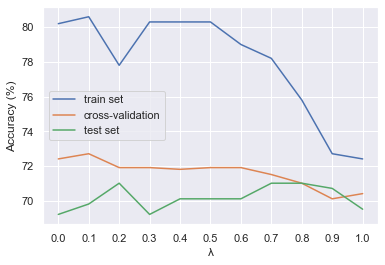

In [38]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0.0, 1.1, 0.1))
ax.set(xlabel='λ', ylabel='Accuracy (%)')
for i in range(3):
    sns.lineplot(x=np.arange(0.0, 1.1, 0.1), y=list(zip(*scores))[i], ax=ax)
    ax.legend(labels=['train set', 'cross-validation', 'test set'])

[Text(0.5, 0, 'λ'), Text(0, 0.5, 'Disparate Impact score')]

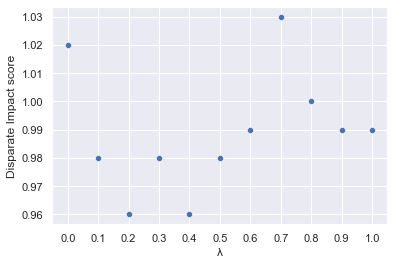

In [43]:
fig, ax = plt.subplots()
ax.set_xticks(np.arange(0.0, 1.1, 0.1))
sns.scatterplot(x=np.arange(0.0, 1.1, 0.1), y=list(zip(*scores))[3])
ax.set(xlabel='λ', ylabel='Disparate Impact score')

<AxesSubplot:>

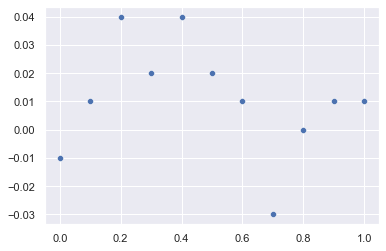

In [40]:
sns.scatterplot(x=np.arange(0.0, 1.1, 0.1), y=list(zip(*scores))[4])